In [1]:
### First imports and default parameters

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Overwritting matplotlib default linestyle of negative contours
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

SEED = 42

# 1. First steps with unsupervised anomaly detection algorithms

The goal of this section is to get familiar with different unsupervised anomaly detection approaches and algorithms. In order to visualise the output of the different algorithms we consider a toy data set consisting in a two-dimensional Gaussian mixture.

### Generating the data set

In [2]:
from utils import GaussianMixture

n_samples = 500
n_features = 2
weight_1 = 0.5
weight_2 = 0.5
mean_1 = np.zeros(n_features)
mean_2 = -1 * np.ones(n_features)
cov_1 = np.array([[2., 2.,], [2., 4.]])
cov_2 = 2 * np.identity(n_features)
weights = np.array([weight_1, weight_2])
means = np.array([mean_1, mean_2])
covars = np.array([cov_1, cov_2])

gm = GaussianMixture(weights, means, covars, random_state=SEED)
X = gm.sample(n_samples)

### Plot the samples and levels set of the density

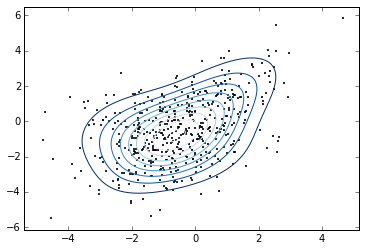

In [3]:
X_range = np.zeros((n_features, 2))
X_range[:, 0] = np.min(X, axis=0)
X_range[:, 1] = np.max(X, axis=0)

h = 0.1  # step size of the mesh
x_min, x_max = X_range[0, 0] - 0.1, X_range[0, 1] + 0.1
y_min, y_max = X_range[1, 0] - 0.1, X_range[1, 1] + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]
Z = gm.density(grid)
Z = Z.reshape(xx.shape)

plt.figure()
plt.contour(xx, yy, Z, 10, cmap=plt.cm.Blues_r)
plt.scatter(X[:, 0], X[:, 1], s=1.)
plt.show()

The goal is to estimate a Minimum volume set with mass at least 0.95. We know that under regularity assumption of the underlying distribution a Minimum volume set is a density level set of the density $f$.
$$
\{x, f(x) \geq F_f^{-1}(1-\alpha) \}
$$
where $F_f^{-1}(1-\alpha)$ is the quantile of order $1-\alpha$ of the distribution of the random variable $f(X)$.

1. Draw a sample $\mathcal{S}$ from the previous Gaussian mixture of size $n = 1,000,000$.

2. Using the sample $\mathcal{S}$ and the true density $f$ given by `gm.density` compute the empirical quantile of order $1-\alpha$ for $\alpha = 0.95$ and $\alpha = 0.99$. You can use for instance the `scipy.stats.mstats.mquantiles` function.

3. Plot the corresponding Minimum Volume set in a figure like the previous one, using `plt.contour` and replacing the number of levels (10) by the threshold you computed: `levels=threshold`.

4. Emphasize the outliers (for instance use a different color) in the previous plot where an outlier is a sample outside the Minimum Volume set.

## 1.1. Density estimation

We are going to use the plug-in approach to estimate the Minimum Volume set with mass at least 0.95. The plug-in approach means that we replace the density $f$ by an estimate $\hat f$.

1. Equation of the corresponding Minimum Volume set estimate.

2. Using a Gaussian kernel, compute a kernel density estimator of $f$. To stick with `sklearn` you can use `sklearn.neighbors.kde.KernelDensity` with the default bandwidth.

3. Compute the empirical quantile $\widehat F_{\hat f}^{-1}(1-\alpha)$ from the original sample for $\alpha = 0.95$ (still using the function `mquantiles`).

4. Add the corresponding Minimum Volume set estimate to the previous plot to visualize the difference between the true MV set and the estimated one.

### Bandwidth selection with cross validation

We used the default bandwidth.

1. Use cross validation to learn the bandwidth from the data. You may use `sklearn.model_selection.GridSearchCV` to perform a 3-fold cross validation.

2. Plot the Minimum Volume set estimate obtained with the learnt bandwidth.

## 1.2. One-Class SVM

The One-Class SVM separates the data from the origin by solving the following optimization problem.

\begin{equation}
\min_{\boldsymbol{w},\boldsymbol{\xi},\rho} \quad \frac{1}{2}\Vert \boldsymbol{w} \Vert^2 - \rho + \frac{1}{\nu n}\sum_{i=1}^n\xi_i\\
\text{s.t.} \quad \langle \boldsymbol{w}, \Phi(x_i) \rangle \geqslant \rho - \xi_i, \quad \xi_i \geqslant 0 \quad \quad 1 \leqslant i \leqslant n 
\end{equation}

where the parameter $\nu \in (0,1)$ has to be set by the user and controls the proportion of outliers.

It is in general solved via the dual given by
\begin{equation}
\min_{\boldsymbol{\alpha}} \quad \frac{1}{2}\sum_{i,j} k(x_i, x_j)\\
\text{s.t.} \quad 0 \leqslant \alpha_i \leqslant \frac{1}{\nu n},\quad \sum_{i}\alpha_i = 1 \quad \quad 1 \leqslant i \leqslant n 
\end{equation}

1. Show that when using a Gaussian kernel, all data in the feature space lies on the same hypersphere. Show that data are always linearly separable from the origin. Hint: what's the formula of $k(x, x')$ in terms of the feature map $\Phi$.

Under mild assumptions the following inequality holds true for all sample size $n$:

$$ \frac{\text{Outliers}}{n} \leq \nu \leq \frac{\text{Support Vectors}}{n} $$.

Futhermore the two fractions on the left-hand side and right-hand converge almost surely towards $\nu$.

1. If we want to estimate a Minimum Volume set with mass at least $\alpha$, how can we set $\nu$?

2. Use `sklearn.svm.OneClassSVM` with the default parameters (except the parameter $\nu$ set according to the previous question) to learn a Minimum Volume set with mass at least $0.95$.

3. Plot the Minimum Volume set estimate.

1. What do you notice? The kernel used by the One-Class SVM is given by $$ k(x, x') = \exp(-\gamma\Vert x - x' \Vert^2). $$

2. What is the default gamma used when we trained the One-Class SVM? Do we need to increase or decrease its value?

### Support vectors - Outliers

1. Check that we indeed have $$ \frac{\text{Outliers}}{n} \leq \nu \leq \frac{\text{Support Vectors}}{n} $$.

2. Use `gamma=10`. Is the inequality always satisfy? Can you guess why?

Only the support vectors are involved in the decision function of the One-Class SVM.

1. Plot the level sets of the One-Class SVM decision function as we dit for the true density.
2. Emphasize the Support vectors.

1. Concerning the support vectors, what is the main difference between the OneClass SVM and a Kernel Density estimator when using a Gaussian Kernel?

2. When is it particularly advantageous to use the OneClass SVM?

### What if we change the value of $\nu$?

1. Set $\nu = 0.4$. How can we estimate a Minimum Volume set with mass at least $0.95$. Hint: Use the `decision_function`.

### Equivalence with SVDD

Support Vector Data Description consists in finding the ball of minimum volume containing an arbitrary proportion of data. This is obtained by minimizing the following optimization problem.

\begin{equation}
\min_{R, \boldsymbol{\xi},\boldsymbol{c}}  \quad R^2 + \frac{1}{\nu n}\sum_{i=1}^{n}\xi_i\\
    \text{s.t.} \quad \Vert \boldsymbol{x}_i - \boldsymbol{c}\Vert^2 \leqslant R^2 + \xi_i, \quad \xi_i \geqslant 0 \quad \quad 1\leqslant i \leqslant n\\
\end{equation}

It is in general solved via the dual given by
\begin{equation}
\min_{\boldsymbol{\alpha}} \quad \sum_{i,j} k(x_i, x_j) + \sum_{i}\alpha_i k(x_i,x_i)\\
\text{s.t.} \quad 0 \leqslant \alpha_i \leqslant \frac{1}{\nu n},\quad \sum_{i}\alpha_i = 1 \quad \quad 1 \leqslant i \leqslant n 
\end{equation}

1. When are SVDD and the One-Class SVM equivalent?

## 1.3. Isolation Forest

1. Run Isolation with `n_estimators=1` , i.e., only one tree will be built.

2. Plot the contour of the set with the $95\%$ most normal observations. Hint: use the `decision_function` and the `contamination` parameter. Compare it with the true Minimum Volume set with mass at least $0.95$.

3. Increase `n_estimators` to 50, 100 and then 500.

4. What does the `max_sample` parameter change?

## 1.4. Local Outlier Factor

k-NN based anomaly detection algorithm. Available on the dev version of Scikit-Learn.

## 1.5. Unsupervised as supervised using SVM

Let $P$ be a distribution with finite support $C$. Let $\mu$ be the uniform distribution over the support $C$: $\mu(A) = \lambda(A)/\lambda(C)$. We now consider the joint distribution $Q$ of $(X, Y) \in \mathbb{R}^d \times \{-1, +1\}$ given by the class conditionals distributions:

$$
X \vert Y= +1 \sim P \quad \text{and} \quad X \vert Y=-1 \sim \mu
$$
and a priori class probabilities $p = \mathbb{P}(Y=1)$.

We are as before interested in finding a given density level set $\{ f \geq \tau \}$ where $f$ is the density of $P$ with respect to the Lebesgue measure $\lambda$.

The marginal distribution of $X$, $P_X$, is given by
$$
P_X = p P + (1-p) Q.
$$

Assuming that $P$ has a density $f$. It can be shown that

$$\eta(x) = P(Y=1\vert X=x) = \frac{pf(x)}{pf(x) + (1-p)/\lambda(C)}$$

The optimal classification set is given by $\{ \eta \geq 1/2 \}$

1. Show that if $p=1/(1 + \lambda(C)\tau)$ then $\lambda(\{\eta \geq 1/2 \} \Delta \{f \geq \tau \} ) = 0$

Thus solving a binary classification problem assigning weights $p$ and $1-p$ to the samples can lead to a density level set.

# 2. Anomaly scoring and Mass Volume curve

Usually unsupervised anomaly detection algorithms returns a scoring function $s$ such that the smaller $s(x)$ the more abnormal $x$ is. To assess the performance of such a scoring function we can use the Mass Volume curve. The MV curve of a scoring function $s$ is given for all $\alpha \in (0,1)$ by
$$
MV_s(\alpha) = \lambda\{x, s(x) \geq F_s^{-1}(1-\alpha) \}
$$
where $F_s^{-1}(1-\alpha)$ is the quantile of order $1-\alpha$ of the distribution of the random variable $s(X)$.

Under regularity assumptions, the MV curve is also given by the parametric curve

$$
(\mathbb{P}(s(X) \geq t), \lambda(x, s(x) \geq t))
$$


Assume that the random variable $X$ with distribution $P$ has a density $f$ with respect to the Lebesgue measure. Furthermore assume that for all $\alpha \in (0,1)$ the Minimum Volume set optimization problem
$$
\min_{\Omega \in \mathcal{M}} \lambda(\Omega) \quad \text{ s.t } \quad P(\Omega) \geq \alpha .
$$
has a unique solution given by
$$
\Omega^*_{\alpha} = \{x, f(x) \geq F_f^{-1}(1-\alpha) \}.
$$

1. Show that for all $\alpha \in (0,1)$, $MV_s(\alpha) - MV_f(\alpha) \leq \lambda(\Omega^*_{\alpha} \Delta \{x, s(x) \geq F_s^{-1}(1-\alpha) \})$.

2. Show that for all $\alpha \in (0,1)$, $MV_f(\alpha) \leq MV_s(\alpha)$. Hint: use the following property: for all $\alpha \in (0,1)$, $\mathbb{P}(s(X) < F_s^{-1}(1-\alpha)) \leq 1-\alpha$.

3. In what sense a scoring function minimizing the area under the Mass Volume curve is optimal?


## 2.1. Using Mass Volume curve for performance evaluation

The lower $MV_s$ the better the scoring function $s$. The goal is to compare the performance of scoring functions given by the One-Class SVM for different values of $\gamma$ using the Mass Volume curve. To easily plot the Mass Volume we are going to use the ROC curve function given by `sklearn`. The idea is to use a uniform sample as the positive class and to consider the Gaussian mixture data set as the negative class. To plot the MV curve we want to plot the volume against the mass $\alpha$. This will be given by $1-TPR$ against $1-FPR$.

1. Using `sklearn.model_selection.ShuffleSplit` split the data set into a training set and a test set.

2. Generate `n_sim=100000` uniform random variables in the hypercube enclosing the data using `numpy.random.uniform`.

3. Build a training set consisting in the concatenation of the training set of the Gaussian mixture data set (obtained in 1.) and the uniform sample.

4. Similarly, build the test set by concatenating the test set of the Gaussian mixture data set (obtained in 1.) and the uniform sample.

1. Compute the Mass Volume curve, estimated on the training set, of the scoring function obtained with the One-Class SVM for $\gamma=0.05$ and $\gamma=10$. Compute the area under the Mass Volume curve for each value of $\gamma$.

2. Compute the Mass Volume curve estimated on the test set for each value of $\gamma$. Compute the area under the Mass Volume curve for each value of $\gamma$.

# 3. Performance evaluation on real data sets

## 3.1. Shuttle data set

In [32]:
from sklearn.datasets import fetch_mldata

dataset = fetch_mldata('shuttle')
X = dataset.data
y = dataset.target

### Usual setup when using this data set for anomaly detection
# Instances with label 4 are removed
# Normal data: label 1
ind = (y != 4)
X = X[ind, :]
y = y[ind]
y = (y == 1).astype(int)

In [33]:
n_samples, n_features = X.shape
n_samples, n_features

(85849, 9)

1. What's the proportion of anomalies in the data set (label 0)?
2. Split the data set into a training a test set using `StratifiedShuffleSplit` to preserve the proportion of each class in the training and test sets.
3. Compare the performance of the OneClass SVM and Isolation Forest using the ROC curve (computed with the true labels) on the train set and the set set:
    - train the algorithm on the training set (without the labels), compute the ROC curve on the training set using the labels.
    - train the algorithm on the training set (without the labels), compute the ROC curve on the test set using the labels
4. Compare the performance of the OneClass SVM and Isolation Forest using the Mass Volume curve on the training and test sets

## 3.2. Http data set - Network intrusion detection

1. Same questions with the http data set

In [40]:
from sklearn.datasets import fetch_kddcup99

dataset = fetch_kddcup99(subset='http', shuffle=True,
                         percent10=True, random_state=SEED)
X = dataset['data']
X = X.astype('float')
y = dataset['target']
y = (y == 'normal.').astype(int)

In [52]:
n_samples, n_features = X.shape

### Novelty detection

Now we only train the model on normal data. For instance let's train the model on half the normal data.

1. Split the data set into a set with the normal data and a set with the anomalies.

2. Randomly split the normal data set into a two data sets: a training set and a test set.

3. Build a test set from the normal test set and the anomalies.

4. Train the OneClass SVM and Isolation Forest on the normal training set and compute the ROC curve on the test set.

#### ROC - AUC on test set

#### MV curve on test set

1. Plot the MV curve estimated on the test set for the OneClass SVM and Isolation Forest.

# 4. Optional 

1. Show that a density level set $\{f \geq \tau \}$ is a Minimum volume set with mass $\alpha = \mathbb{P}(f(X) \geq \tau)$.

2. Show that if the density has not flat parts, the minimum volume set optimization problem has a solution.

# 5. Overfitting for Minimum volume set estimation

Let $\lambda$ denotes the Lebesgue measure of $\mathbb{R}^d$ and let $\mathcal{M}$ be the class of all measurable sets. A Minimum Volume set with mass at least $\alpha$ is the solution of the following optimization problem:
$$
\min_{\Omega \in \mathcal{M}} \lambda(\Omega) \quad \text{ s.t } \quad P(\Omega) \geq \alpha .
$$
We do not know the distribution $P$ but only have a sample $X_1, \dots, X_n$ drawn from this distribution. 

1. What is the solution for all $\alpha \in (0,1)$ of the empirical optimization problem if we solve the following empirical version of the Minimum Volume set optimization problem:
$$
\min_{\Omega \in \mathcal{M}} \lambda(\Omega) \quad \text{ s.t } \quad \widehat P(\Omega) \geq \alpha
$$
where for all $\Omega$, $\widehat P(\Omega) = \frac{1}{n}\sum_{i=1}^n \mathbb{I}\{X_i \in \Omega \}$.